In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [82]:
# Load data
daily_activity = pd.read_csv('dailyActivity_merged.csv')
heartrate_seconds = pd.read_csv('heartrate_seconds_merged.csv')
hourly_calories = pd.read_csv('hourlyCalories_merged.csv')
hourly_intensities = pd.read_csv('hourlyIntensities_merged.csv')
hourly_steps = pd.read_csv('hourlySteps_merged.csv')
minute_calories = pd.read_csv('minuteCaloriesNarrow_merged.csv')
minute_intensities = pd.read_csv('minuteIntensitiesNarrow_merged.csv')
minute_mets = pd.read_csv('minuteMETsNarrow_merged.csv')
minute_sleep = pd.read_csv('minuteSleep_merged.csv')
minute_steps = pd.read_csv('minuteStepsNarrow_merged.csv')
weight_log = pd.read_csv('weightLogInfo_merged.csv')

In [84]:
# Convert timestamps to datetime objects
daily_activity['ActivityDate'] = pd.to_datetime(daily_activity['ActivityDate'], format='%m/%d/%Y')
heartrate_seconds['Time'] = pd.to_datetime(heartrate_seconds['Time'], format= '%m/%d/%Y %H:%M:%S %p')
hourly_calories['ActivityHour'] = pd.to_datetime(hourly_calories['ActivityHour'], format='%m/%d/%Y %H:%M:%S %p')
hourly_intensities['ActivityHour'] = pd.to_datetime(hourly_intensities['ActivityHour'], format='%m/%d/%Y %H:%M:%S %p')
hourly_steps['ActivityHour'] = pd.to_datetime(hourly_steps['ActivityHour'], format='%m/%d/%Y %H:%M:%S %p')
minute_calories['ActivityMinute'] = pd.to_datetime(minute_calories['ActivityMinute'], format='%m/%d/%Y %H:%M:%S %p')
minute_intensities['ActivityMinute'] = pd.to_datetime(minute_intensities['ActivityMinute'], format='%m/%d/%Y %H:%M:%S %p')
minute_mets['ActivityMinute'] = pd.to_datetime(minute_mets['ActivityMinute'], format='%m/%d/%Y %H:%M:%S %p')
minute_sleep['date'] = pd.to_datetime(minute_sleep['date'], format='%m/%d/%Y %H:%M:%S %p')
minute_steps['ActivityMinute'] = pd.to_datetime(minute_steps['ActivityMinute'], format='%m/%d/%Y %H:%M:%S %p')
weight_log['Date'] = pd.to_datetime(weight_log['Date'], format='%m/%d/%Y %H:%M:%S %p')

In [86]:
# Handle missing values
daily_activity.ffill(inplace=True)
heartrate_seconds.ffill(inplace=True)
hourly_calories.ffill(inplace=True)
hourly_intensities.ffill(inplace=True)
hourly_steps.ffill(inplace=True)
minute_calories.ffill(inplace=True)
minute_intensities.ffill(inplace=True)
minute_mets.ffill(inplace=True)
minute_sleep.ffill(inplace=True)
minute_steps.ffill(inplace=True)
weight_log.ffill(inplace=True)

# Handle duplicates
daily_activity.drop_duplicates(inplace=True)
heartrate_seconds.drop_duplicates(inplace=True)
hourly_calories.drop_duplicates(inplace=True)
hourly_intensities.drop_duplicates(inplace=True)
hourly_steps.drop_duplicates(inplace=True)
minute_calories.drop_duplicates(inplace=True)
minute_intensities.drop_duplicates(inplace=True)
minute_mets.drop_duplicates(inplace=True)
minute_sleep.drop_duplicates(inplace=True)
minute_steps.drop_duplicates(inplace=True)
weight_log.drop_duplicates(inplace=True)

In [88]:
# Inspect column names
print("daily_activity columns:", daily_activity.columns)
print("heartrate_seconds columns:", heartrate_seconds.columns)
print("hourly_calories columns:", hourly_calories.columns)
print("hourly_intensities columns:", hourly_intensities.columns)
print("hourly_steps columns:", hourly_steps.columns)
print("minute_calories columns:", minute_calories.columns)
print("minute_intensities columns:", minute_intensities.columns)
print("minute_mets columns:", minute_mets.columns)
print("minute_sleep columns:", minute_sleep.columns)
print("minute_steps columns:", minute_steps.columns)
print("weight_log columns:", weight_log.columns)

daily_activity columns: Index(['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories'],
      dtype='object')
heartrate_seconds columns: Index(['Id', 'Time', 'Value'], dtype='object')
hourly_calories columns: Index(['Id', 'ActivityHour', 'Calories'], dtype='object')
hourly_intensities columns: Index(['Id', 'ActivityHour', 'TotalIntensity', 'AverageIntensity'], dtype='object')
hourly_steps columns: Index(['Id', 'ActivityHour', 'StepTotal'], dtype='object')
minute_calories columns: Index(['Id', 'ActivityMinute', 'Calories'], dtype='object')
minute_intensities columns: Index(['Id', 'ActivityMinute', 'Intensity'], dtype='object')
minute_mets columns: Index(['Id', 'ActivityMinute', 'METs'], dtype='object')
minute_sleep colu

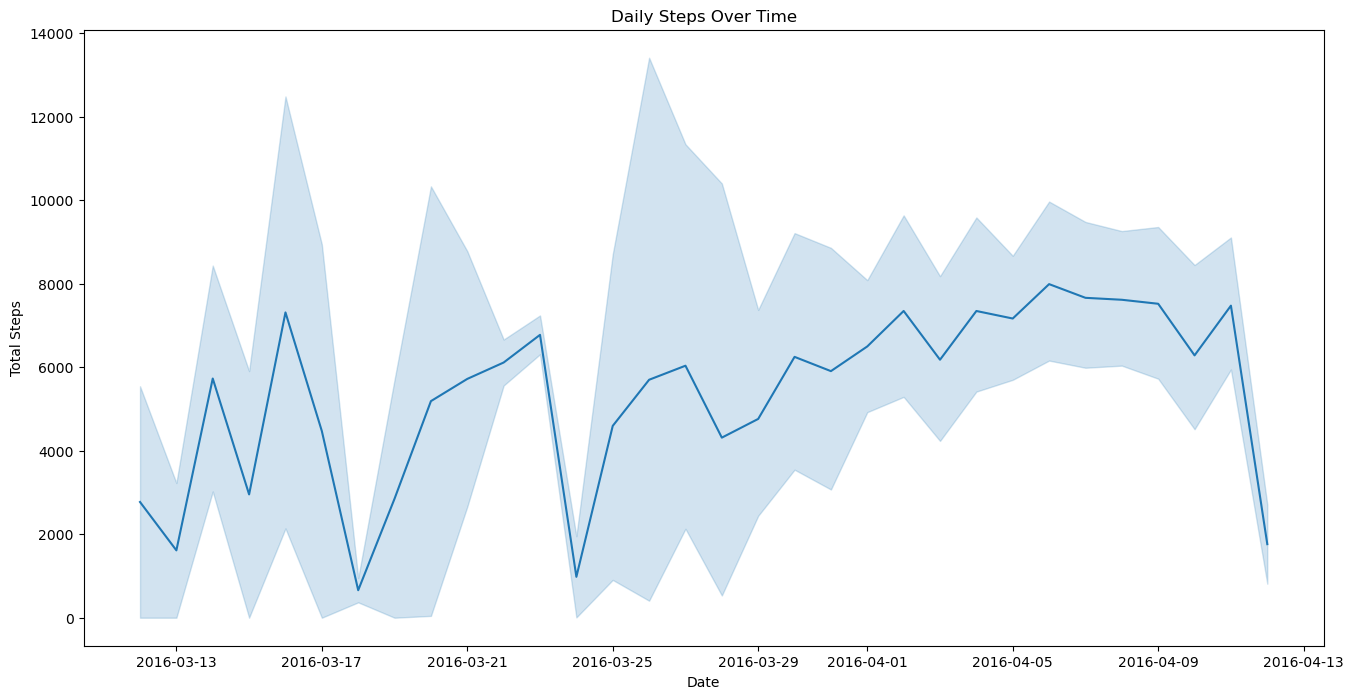

In [90]:
# Example: Plot daily steps
plt.figure(figsize=(16, 8))
sns.lineplot(data=daily_activity, x='ActivityDate', y='TotalSteps')
plt.title('Daily Steps Over Time')
plt.xlabel('Date')
plt.ylabel('Total Steps')
plt.show()

In [92]:
# Aggregate minute-level data to daily data
daily_calories = minute_calories.resample('D', on='ActivityMinute').sum()
daily_intensities = minute_intensities.resample('D', on='ActivityMinute').sum()
daily_steps = minute_steps.resample('D', on='ActivityMinute').sum()

# Merge with daily_activity with suffixes to avoid column name conflicts
daily_data = daily_activity.merge(daily_calories, left_on='ActivityDate', right_index=True, suffixes=('', '_calories'))
daily_data = daily_data.merge(daily_intensities, left_on='ActivityDate', right_index=True, suffixes=('', '_intensities'))
daily_data = daily_data.merge(daily_steps, left_on='ActivityDate', right_index=True, suffixes=('', '_steps'))

# Display the columns of the merged DataFrame
print(daily_data.columns)

# Calculate TotalMinutes as the sum of various active and sedentary minutes
daily_data['TotalMinutes'] = daily_data[['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes']].sum(axis=1)

# Create additional features
daily_data['ActiveMinutesPct'] = daily_data['VeryActiveMinutes'] / (daily_data['TotalMinutes'] + 1)  # Avoid division by zero

# Display the first few rows to ensure everything is merged correctly
print(daily_data.head())

Index(['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories', 'Id_calories',
       'Calories_calories', 'Id_intensities', 'Intensity', 'Id_steps',
       'Steps'],
      dtype='object')
           Id ActivityDate  TotalSteps  TotalDistance  TrackerDistance  \
0  1503960366   2016-03-25       11004           7.11             7.11   
1  1503960366   2016-03-26       17609          11.55            11.55   
2  1503960366   2016-03-27       12736           8.53             8.53   
3  1503960366   2016-03-28       13231           8.93             8.93   
4  1503960366   2016-03-29       12041           7.85             7.85   

   LoggedActivitiesDistance  VeryActiveDistance  ModeratelyActiveDistance  \
0                 

                 Id                   ActivityDate    TotalSteps  \
count  4.570000e+02                            457    457.000000   
mean   4.628595e+09  2016-04-04 04:40:26.258205696   6329.954048   
min    1.503960e+09            2016-03-12 00:00:00      0.000000   
25%    2.347168e+09            2016-04-02 00:00:00   1988.000000   
50%    4.057193e+09            2016-04-05 00:00:00   5986.000000   
75%    6.391747e+09            2016-04-08 00:00:00  10106.000000   
max    8.877689e+09            2016-04-12 00:00:00  20779.000000   
std    2.293781e+09                            NaN   4999.631725   

       TotalDistance  TrackerDistance  LoggedActivitiesDistance  \
count     457.000000       457.000000                     457.0   
mean        4.405405         4.377396                       0.0   
min         0.000000         0.000000                       0.0   
25%         1.410000         1.280000                       0.0   
50%         4.090000         4.090000               

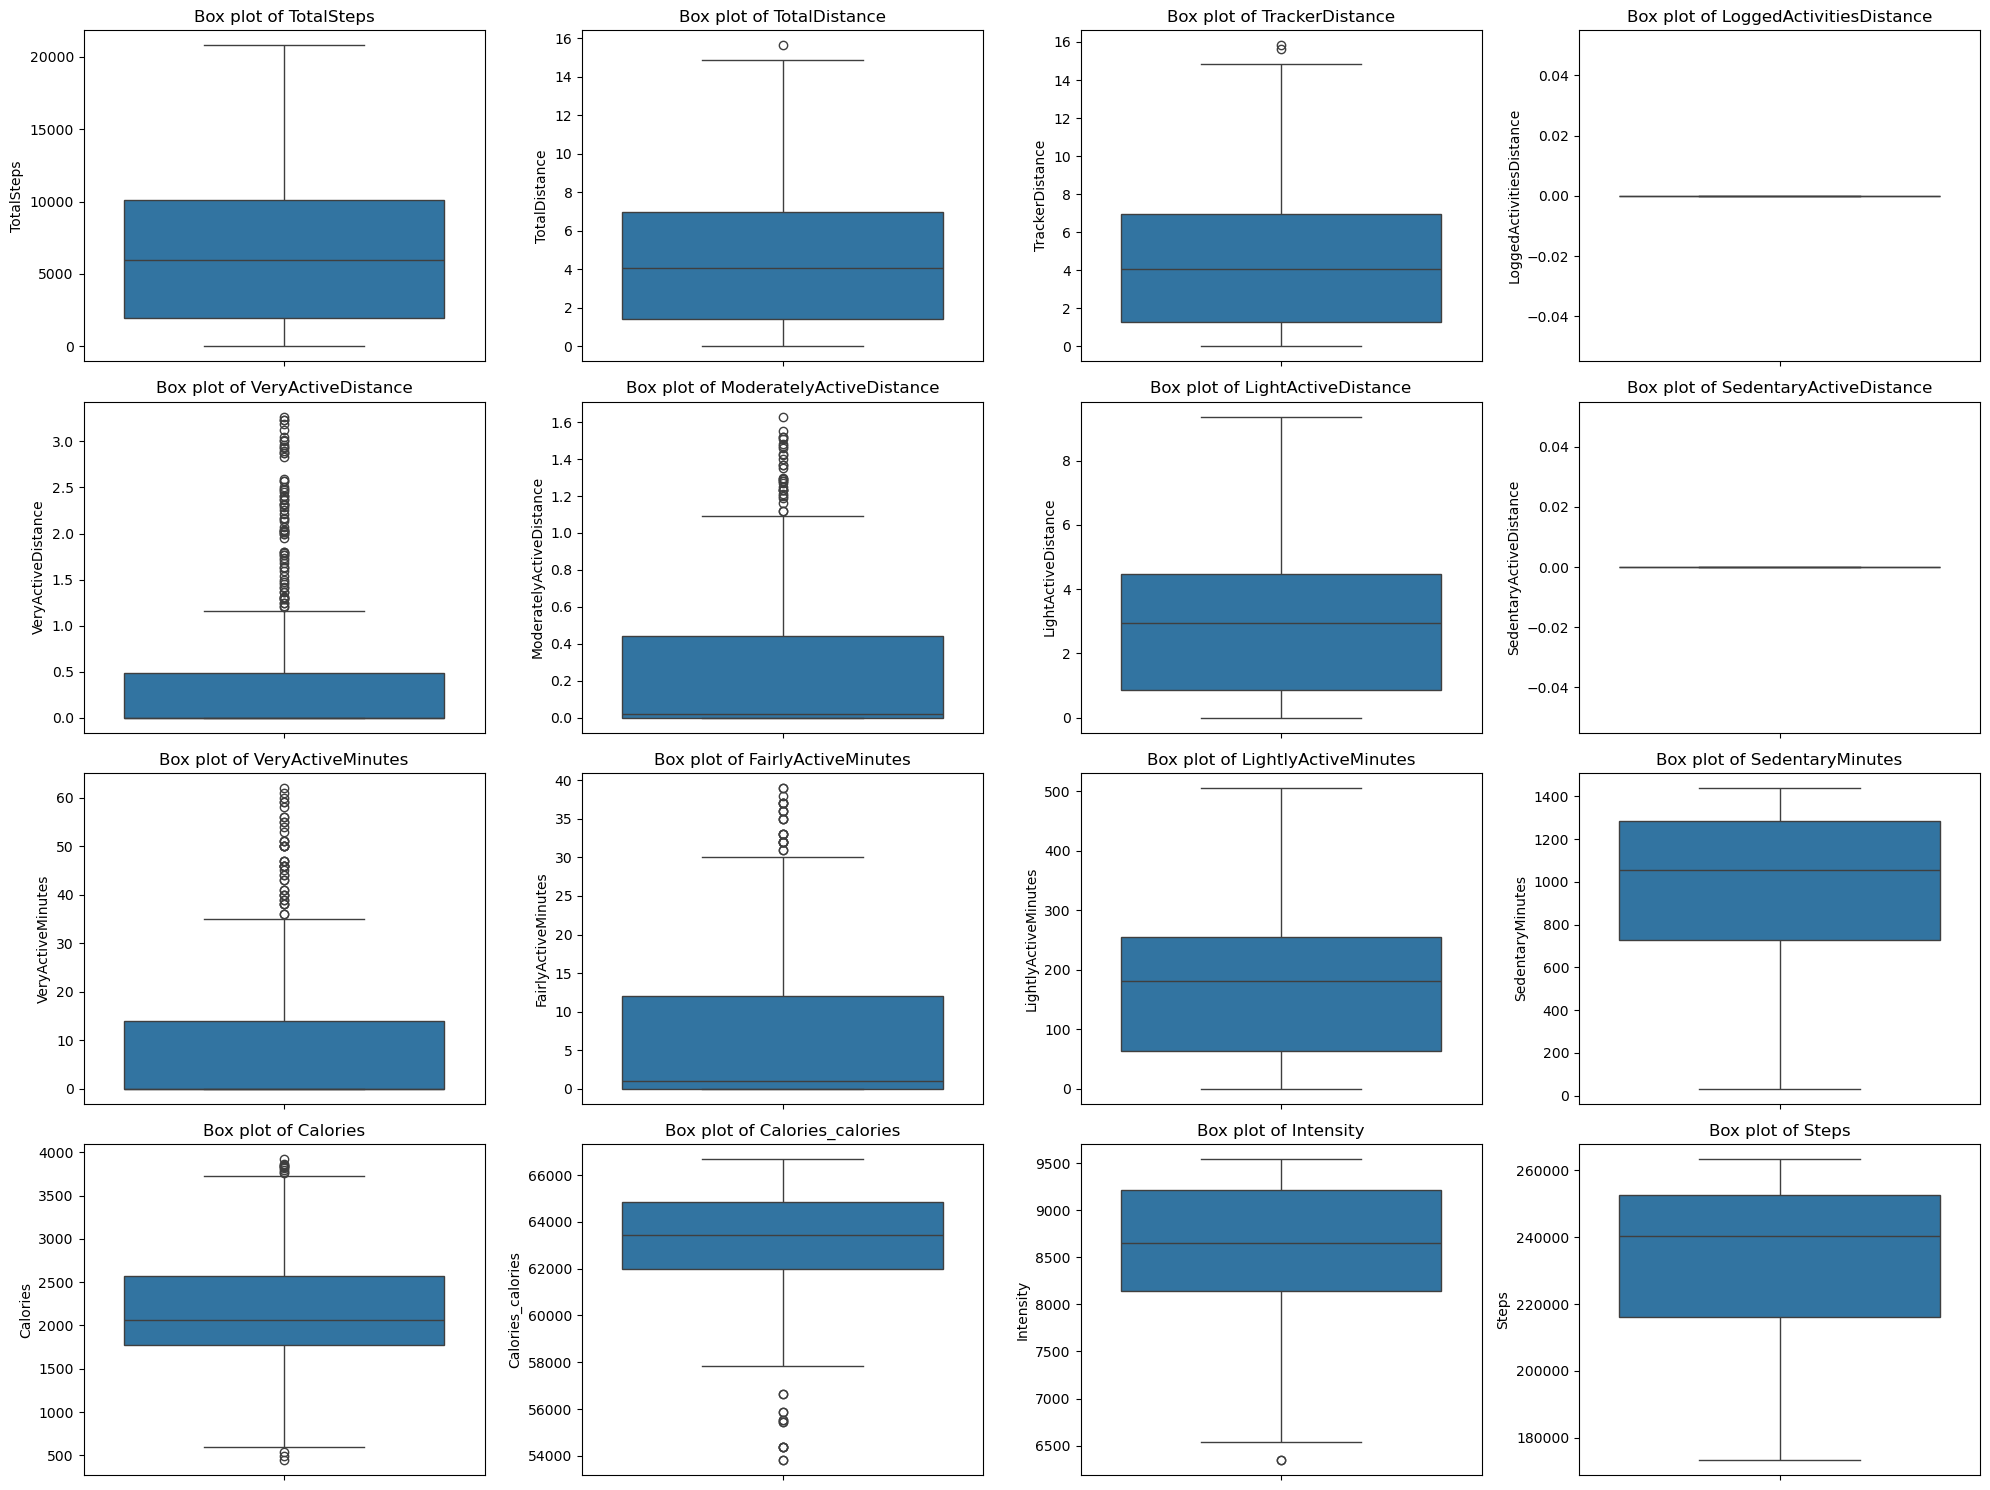

In [94]:
# Function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Function to handle outliers by replacing with median
def handle_outliers(df, column):
    outliers = detect_outliers_iqr(df, column)
    median = df[column].median()
    df.loc[outliers.index, column] = median
    return df

# Select numerical columns
numerical_columns = ['TotalSteps', 'TotalDistance', 'TrackerDistance', 'LoggedActivitiesDistance',
                     'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance',
                     'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
                     'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories', 'Calories_calories',
                     'Intensity', 'Steps']

# Detect and handle outliers for each numerical column
for column in numerical_columns:
    daily_data = handle_outliers(daily_data, column)

# Verify that outliers are handled
print(daily_data.describe())

# Function to create box plots for each numerical column
def create_box_plots(df, columns):
    plt.figure(figsize=(20, 15))
    for i, column in enumerate(columns, 1):
        plt.subplot(4, 4, i)
        sns.boxplot(y=df[column])
        plt.title(f'Box plot of {column}')
    plt.tight_layout()
    plt.show()

# Create box plots for the numerical columns
create_box_plots(daily_data, numerical_columns)

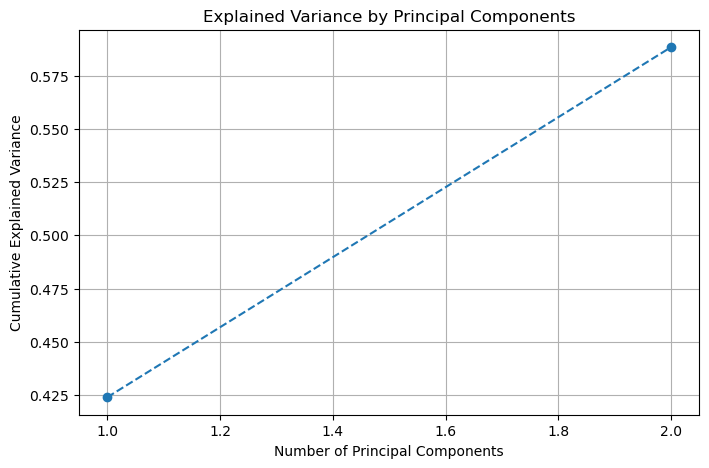

        PC1       PC2
0  1.884957  4.640333
1  3.115010  2.819627
2  2.256234  1.367246
3  3.691676  1.221414
4  3.474717  1.202515


In [96]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(daily_data[numerical_columns])

# Apply PCA
pca = PCA(n_components=2)  # Adjust n_components as needed
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Visualize the explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Display the first few rows of the PCA DataFrame
print(pca_df.head())

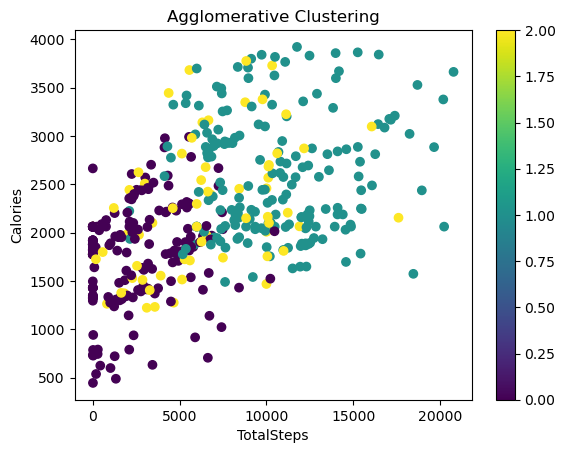

In [98]:
# Initialize AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_clustering.fit(scaled_data)
daily_data['Cluster_Agg'] = agg_clustering.labels_

# Example: Scatter plot of clusters
plt.scatter(daily_data['TotalSteps'], daily_data['Calories'], c=daily_data['Cluster_Agg'], cmap='viridis')
plt.xlabel('TotalSteps')
plt.ylabel('Calories')
plt.title('Agglomerative Clustering')
plt.colorbar()
plt.show()

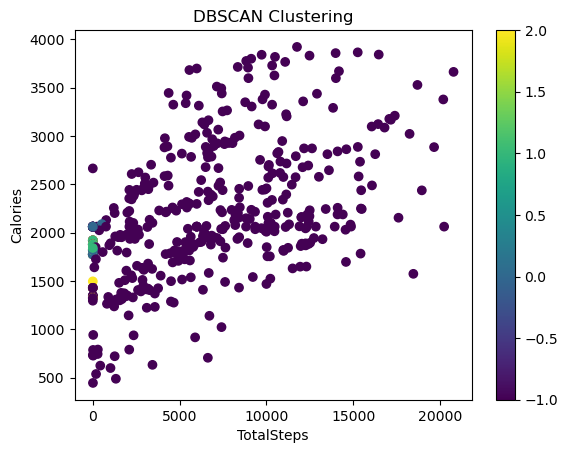

In [100]:
# Initialize DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(scaled_data)
daily_data['Cluster_DBSCAN'] = dbscan.labels_

# Scatter plot of clusters for DBSCAN
plt.scatter(daily_data['TotalSteps'], daily_data['Calories'], c=daily_data['Cluster_DBSCAN'], cmap='viridis')
plt.xlabel('TotalSteps')
plt.ylabel('Calories')
plt.title('DBSCAN Clustering')
plt.colorbar()
plt.show()

In [102]:
# Evaluate clustering with silhouette score
silhouette_agg = silhouette_score(scaled_data, daily_data['Cluster_Agg'])
silhouette_dbscan = silhouette_score(scaled_data, daily_data['Cluster_DBSCAN'])
print(f"Silhouette Score for Agglomerative Clustering: {silhouette_agg}")
print(f"Silhouette Score for DBSCAN Clustering: {silhouette_dbscan}")

Silhouette Score for Agglomerative Clustering: 0.24351815477320793
Silhouette Score for DBSCAN Clustering: -0.055044536235651455


In [104]:
# Example: Predict daily calories burned
X = daily_data[numerical_columns]
y = daily_data['Calories']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomForestRegressor and GridSearchCV
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best RandomForest model
best_rf_model = grid_search.best_estimator_

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
{'bootstrap': True, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.9991938534867411
RandomForestRegressor(max_depth=10, max_features=None, min_samples_leaf=2)


In [106]:
# Evaluate RandomForest model
y_pred_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Evaluate Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, lr_pred)
r2_lr = r2_score(y_test, lr_pred)

# Evaluate SVM model
svm_model = SVR()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
mse_svm = mean_squared_error(y_test, svm_pred)
r2_svm = r2_score(y_test, svm_pred)

# Print evaluation metrics
print(f'Random Forest MSE: {mse_rf}, R2: {r2_rf}')
print(f'Linear Regression MSE: {mse_lr}, R2: {r2_lr}')
print(f'SVM MSE: {mse_svm}, R2: {r2_svm}')

Random Forest MSE: 151.15347273864464, R2: 0.9996838034487945
Linear Regression MSE: 2.5160873051568394e-22, R2: 1.0
SVM MSE: 499898.2966354123, R2: -0.045732621856079625


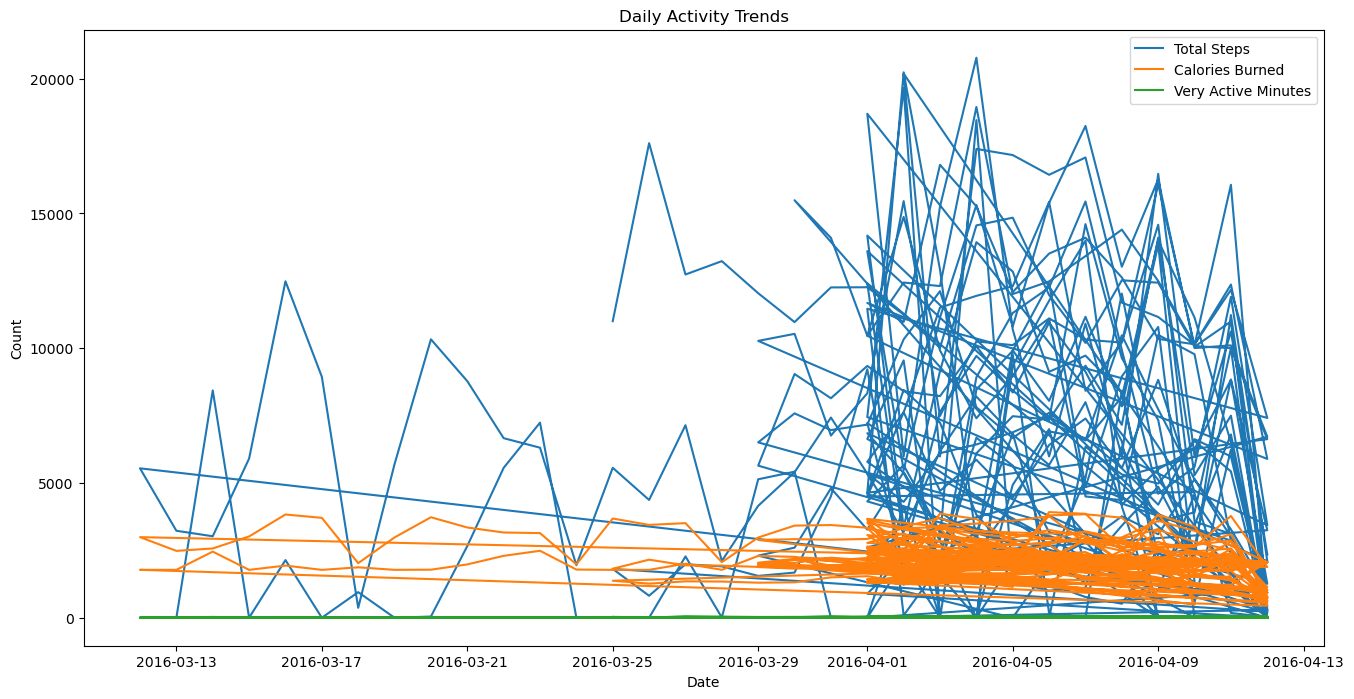

In [108]:
# Example: Daily activity trends
plt.figure(figsize=(16, 8))
plt.plot(daily_data['ActivityDate'], daily_data['TotalSteps'], label='Total Steps')
plt.plot(daily_data['ActivityDate'], daily_data['Calories'], label='Calories Burned')
plt.plot(daily_data['ActivityDate'], daily_data['VeryActiveMinutes'], label='Very Active Minutes')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily Activity Trends')
plt.legend()
plt.show()